In [1]:
from dask.distributed import Client

client = Client(n_workers=8, threads_per_worker=8)
client

Client Scheduler: tcp://127.0.0.1:40500 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 64 Memory: 270.24 GB


In [2]:
%matplotlib inline
import pylab as pl

In [3]:
import os
os.chdir('/lustre/cv/projects/ALMA_IMF/2017.1.01355.L/imaging_results')

In [4]:
import dask
print(dask.__version__)

2.2.0


In [5]:
import intake, intake_astro
print(intake.__version__, intake_astro.__version__)

0.5.2 0+unknown


In [6]:
from astropy import stats
import dask

In [7]:
import numpy as np

In [8]:
from scipy import ndimage

In [9]:
from scipy import fftpack
import scipy.fftpack

#cube = SpectralCube.read('W51-E_B3_spw1_12M_lines.image.fits')

source = intake.open_fits_array('W51-E_B3_spw1_12M_lines.image.fits', ext=0, chunks=(1, 1920, 32, 32))
darr = source.to_dask()  # for parallel access,

#dask.array.apply_along_axis?

#sigclip_op.rechunk((1,1920,1,1)).visualize()
#sigclip_op.visualize()

sigclip_op = dask.array.apply_along_axis(arr=darr, func1d=stats.sigma_clip, sigma=1.8, axis=1, shape=(1920,))

sigclip_op.to_zarr(url='sigmaclipped.zarr')

## Try this later:

``sigclip_op.rechunk((1,1920,1,1)).store('sigmaclipped.hdf5', lock=False)``

import dask.array
scarr = dask.array.from_zarr('sigmaclipped.zarr')
scarr

mean = scarr.rechunk((1,1920,128,128)).mean(axis=1)
mean

mean.visualize()

mean_image = mean.compute()

mean_image.shape

pl.figure(figsize=(20,20))
pl.imshow(mean_image.squeeze(), origin='lower', interpolation='none', vmin=-0.01, vmax=0.005)

In [10]:
# To test whether the notebook kernel is still live...
print("TEST")

TEST


from spectral_cube import SpectralCube
cube = SpectralCube.read('W51-E_B3_spw3_12M_lines.image.fits')
cube

sigclip_op_sp3.rechunk((1,1920,128,128))

source = intake.open_fits_array('W51-E_B3_spw3_12M_lines.image.fits', ext=0, chunks=(1, 1920, 128, 128))
darr = source.to_dask()  # for parallel access,

darr

mask = (darr[0,960,:,:] != 0) & (np.isfinite(darr[0,960,:,:]))

pl.imshow(mask)

slices = ndimage.find_objects(mask)
print(slices)

mask.shape

slices, slices[0]

mask[slices[0]].shape

darr.shape

new_slices = [slice(slc.start, slc.start + scipy.fftpack.next_fast_len(slc.stop-slc.start))
              for slc in slices[0]]
new_slices

darr_cropped = darr[:,:,new_slices[0], new_slices[1]]

darr_cropped

for ii in range(2,darr_cropped.shape[2]):
    if darr_cropped.shape[2] % ii == 0:
        print(ii, darr_cropped.shape[2]/ii)
        
for ii in range(2,darr_cropped.shape[3]):
    if darr_cropped.shape[3] % ii == 0:
        print(ii, darr_cropped.shape[3]/ii)

    sigclip_op_sp3 = dask.array.apply_along_axis(arr=darr_cropped.rechunk((1,1920,90,90)),
                                                 func1d=stats.sigma_clip, sigma=1.8, axis=1, shape=(1920,))

sigclip_op_sp3

sigclip_op_sp3.to_zarr(url='W51-E_B3_spw3_12M_lines.image.sigmaclipped.zarr')

mean_op_spw3 = sigclip_op_sp3.mean(axis=1)

mean_spw3 = mean_op_spw3.compute()

pl.figure(figsize=(20,20))
pl.imshow(mean_spw3.squeeze(), origin='lower', interpolation='none', vmin=-0.01, vmax=0.005)

In [11]:
from spectral_cube import SpectralCube
cube = SpectralCube.read('W51-E_B6_spw0_12M_lines.image.fits')
cube

VaryingResolutionSpectralCube with shape=(1920, 1372, 1372) and unit=Jy / beam:
 n_x:   1372  type_x: RA---SIN  unit_x: deg    range:   290.914427 deg:  290.953768 deg
 n_y:   1372  type_y: DEC--SIN  unit_y: deg    range:    14.488966 deg:   14.527049 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 216043248934.970 Hz:216277481246.300 Hz

source = intake.open_fits_array('W51-E_B6_spw0_12M_lines.image.fits', ext=0, chunks=(1, 1920, 128, 128))
darr = source.to_dask()  # for parallel access,

darr

mask = (cube[100,:,:].value != 0) & (np.isfinite(cube[100,:,:]))
#mask = (darr[0,60,:,:] != 0) & (np.isfinite(darr[0,60,:,:]))

pl.imshow(mask)

slices = ndimage.find_objects(mask)
print(slices)

mask.shape

slices, slices[0]

darr.shape

new_slices = [slice(slc.start, slc.start + scipy.fftpack.next_fast_len(slc.stop-slc.start))
              for slc in slices[0]]
new_slices

darr_cropped = darr[:,:,new_slices[0], new_slices[1]]

darr_cropped

In [43]:
def getslices(imagename):
    
    cube = SpectralCube.read(imagename)
    mask = np.isfinite(cube[0,:,:].value) & (cube[0,:,:].value != 0) & (np.abs(cube[0,:,:].value) > 1e-7)
    
    slices = ndimage.find_objects(mask)
    
    new_slices = [slice(slc.start, slc.start + scipy.fftpack.next_fast_len(slc.stop-slc.start))
                  for slc in slices[0]]
    
    return tuple(new_slices)

In [45]:
getslices("W51-E_B3_spw0_12M_lines.image.fits")

(slice(621, 2061, None), slice(674, 2132, None))

In [57]:
def find_sizes(shape):
    print(f"finding sizes for shape {shape}")
    sizes_dim2 = [ii for ii in range(2,shape[2])
                  if shape[2] % ii == 0]
    sizes_dim3 = [ii for ii in range(2,shape[3])
                  if shape[3] % ii == 0]
    both = set(sizes_dim2).intersection(set(sizes_dim3))
    
    best = max((x for x in both if x < 250))
    
    if best < 15:
        print(f"Best match = {best}, shape={shape}, both={both}")
        raise ValueError("Too small!")
    
    return best
        
#find_sizes(darr_cropped.shape)

In [87]:
def get_dask_sigclip_mean(imagename):
    cube = SpectralCube.read(imagename)
    
    source = intake.open_fits_array(imagename, ext=0, chunks=(1, cube.shape[0], 128, 128))
    darr = source.to_dask()
    
    slices = getslices(imagename)
    
    print(f"slices={slices} for file {imagename}")
    
    cropped_darr = darr[(slice(None), slice(None), slices[0], slices[1])]
    
    chunksizes = find_sizes(cropped_darr.shape)
    
    chunkshape = (1, cube.shape[0], chunksizes, chunksizes)
    
    sigclip_out = imagename.replace(".fits", ".sigmaclipped.zarr")
    if os.path.exists(sigclip_out):
        sigclip_op_this = dask.array.from_zarr(sigclip_out)
    else:
        sigclip_op_this = dask.array.apply_along_axis(arr=cropped_darr.rechunk(chunkshape),
                                                       func1d=stats.sigma_clip,
                                                       sigma=1.8, axis=1, shape=(cube.shape[0],))

        sigclip_op_this.to_zarr(url=sigclip_out)
    
    mean_op_this = sigclip_op_this.mean(axis=1)
    
    mean_this = mean_op_this.compute()
    
    mean_this = mean_this.squeeze()
    
    if hasattr(mean_this, 'mask'):
        unmasked_mean = mean_this.data.copy()
        unmasked_mean[mean_this.mask] = np.nan
    else:
        unmasked_mean = mean_this
    
    hdu = cube[0,:,:].hdu
    hdu.data = unmasked_mean
    hdu.writeto(imagename.replace(".fits", "_sigmaclipped_mean.fits"), overwrite=True)
    
    sumspec_op = (sigclip_op_this>0).sum(axis=(2,3))
    sumspec = sumspec_op.compute()
    
    if hasattr(sumspec, 'mask'):
        unmasked_sumspec = sumspec.data.copy()
    else:
        unmasked_sumspec = sumspec
    
    hdu = cube[:,0,0].hdu
    hdu.data = unmasked_sumspec
    hdu.writeto(imagename.replace(".fits", "_sigmaclipped_sumspec.fits"), overwrite=True)
    
    return mean_this, sumspec

W51-E_B3_spw0_12M_lines.image.fits


slices=(slice(621, 2061, None), slice(674, 2132, None)) for file W51-E_B3_spw0_12M_lines.image.fits
finding sizes for shape (1, 1920, 1440, 1458)


W51-E_B6_spw6_12M_lines.contsub.image.fits


/lustre/naasc/users/aginsbur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


slices=(slice(269, 1169, None), slice(307, 1171, None)) for file W51-E_B6_spw6_12M_lines.contsub.image.fits
finding sizes for shape (1, 1920, 900, 864)
slices=(slice(619, 2059, None), slice(670, 2128, None)) for file W51-E_B3_spw1_12M_lines.image.fits
finding sizes for shape (1, 1920, 1440, 1458)


W51-E_B6_spw7_12M_lines.image.fits


/lustre/naasc/users/aginsbur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


IndexError: list index out of range

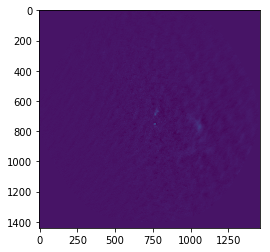

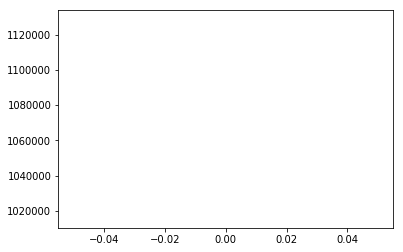

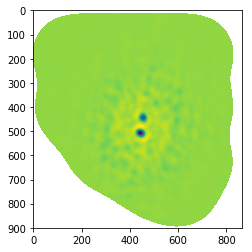

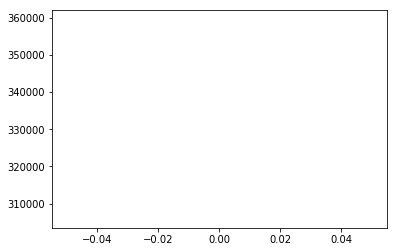

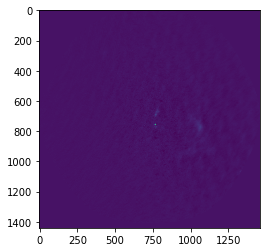

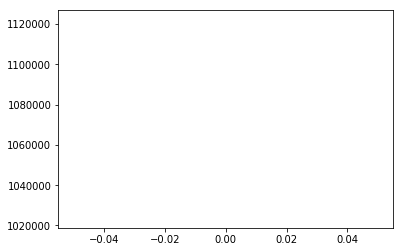

In [90]:
import glob
for fn in glob.glob("*.image.fits"):
    print(fn)
    cont,flagspec = get_dask_sigclip_mean(fn)
    pl.figure()
    pl.imshow(cont.squeeze())
    pl.figure()
    pl.plot(flagspec)

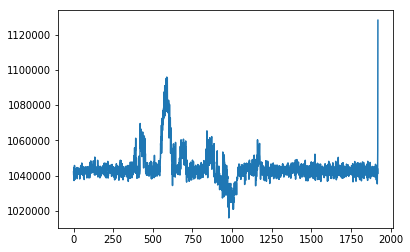

In [86]:
pl.plot(flagspec.squeeze())

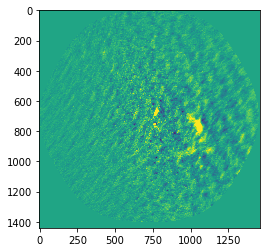

In [84]:
pl.imshow(cont.squeeze(), vmax=0.01)

In [64]:
x = np.ma.arange(5)

In [71]:
x.mask=[True,True,False,False,True]

In [72]:
x, x.data.copy(), x.mask

(masked_array(data=[--, --, 2, 3, --],
              mask=[ True,  True, False, False,  True],
        fill_value=999999),
 array([0, 1, 2, 3, 4]),
 array([ True,  True, False, False,  True]))

In [31]:
cube = SpectralCube.read("W51-E_B3_spw0_12M_lines.image.fits")

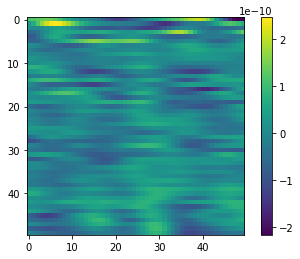

In [42]:
pl.imshow(cube[20,:50,:50].value)#, vmin=-0.001, vmax=0.001)
pl.colorbar()

In [37]:
cube[1,:,:].mask.include()

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

sigclip_op_sp0b6 = dask.array.apply_along_axis(arr=darr_cropped.rechunk((1,1920,96,96)),
                                             func1d=stats.sigma_clip, sigma=1.8, axis=1, shape=(1920,))

sigclip_op_sp0b6

sigclip_op_sp0b6.to_zarr(url='W51-E_B6_spw0_12M_lines.image.sigmaclipped.zarr')

mean_op_spw0b6 = sigclip_op_sp0b6.mean(axis=1)

mean_spw0b6 = mean_op_spw0b6.compute()

pl.figure(figsize=(20,20))
pl.imshow(mean_spw0b6.squeeze(), origin='lower', interpolation='none', vmin=-0.01, vmax=0.005)

In [ ]:
ls -lhrtd *zarr

In [89]:
print("TEST")

TEST


client.close()